# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [35]:
"""

"""
%matplotlib inline

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [79]:
opsimdf.columns

Index(['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'finRank', 'FWHMeff', 'FWHMgeom', 'transparency', 'airmass',
       'vSkyBright', 'filtSkyBrightness', 'rotSkyPos', 'rotTelPos', 'lst',
       'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec',
       'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle',
       'rScatter', 'mieScatter', 'moonIllum', 'moonBright', 'darkBright',
       'rawSeeing', 'wind', 'humidity', 'slewDist', 'slewTime',
       'fiveSigmaDepth', 'ditheredRA', 'ditheredDec'],
      dtype='object')

In [4]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [5]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

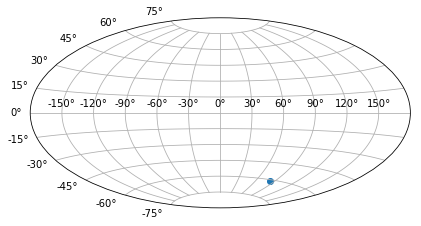

In [6]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [7]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [8]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [9]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
1,567,1.648235,-0.903353,1.678778,1.617692,-0.933896,-0.872810
2,561,1.563788,-0.915583,1.594331,1.533245,-0.946126,-0.885040
3,539,1.477422,-0.924531,1.507965,1.446879,-0.955074,-0.893988
4,531,1.389669,-0.930365,1.420212,1.359126,-0.960908,-0.899822
5,517,1.301075,-0.933239,1.331618,1.270532,-0.963782,-0.902696
6,519,1.212198,-0.933238,1.242741,1.181655,-0.963781,-0.902695
7,523,1.123604,-0.930366,1.154147,1.093061,-0.960909,-0.899823
8,541,1.035849,-0.924530,1.066392,1.005306,-0.955073,-0.893987
9,698,0.988892,-0.827713,1.019435,0.958349,-0.858256,-0.797170


In [10]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

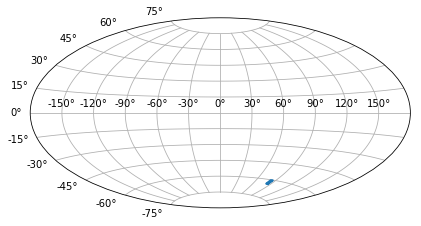

In [11]:
reload(utils)
utils.plot_field(field_df)

In [12]:
field_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
72731,315,4.606702,-1.082473,4.637245,4.576159,-1.113016,-1.05193


In [80]:
mjd_to_sim = opsimdf.loc[opsimdf["fieldID"] == 2846,["expMJD"]].values.T[0]
filters_to_sim = opsimdf.loc[opsimdf["fieldID"] == 2846,["filter"]].values.T[0]
limiting_mags = opsimdf.loc[opsimdf["fieldID"] == 2846,["fiveSigmaDepth"]].values.T[0] 

filters_to_sim = np.array([b('LSST_'+x) for x in filters_to_sim])


In [89]:
opsimdf.loc[opsimdf["fieldID"] == 2846]

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
8190,8190,1068,247,2846,1.694772,0.076277,z,963211,59591.148276,11,...,296.181620,92.169778,0.588724,0.0,0.0,0.049573,4.606308,22.597790,1.685199,0.053132
8230,8230,1068,247,2846,1.694772,0.076277,z,964868,59591.167465,11,...,280.688900,92.261302,0.751027,0.0,0.0,0.049573,4.704252,22.440571,1.685199,0.053132
13483,13483,1068,247,2846,1.694772,0.076277,z,1573406,59598.210719,18,...,1465.957404,100.491399,1.184810,0.0,0.0,0.054177,4.692362,21.390855,1.712003,0.053132
13511,13511,1068,247,2846,1.694772,0.076277,z,1574487,59598.223240,18,...,1522.295659,103.867103,1.269806,0.0,0.0,0.140018,7.328841,21.270356,1.712003,0.053132
13529,13529,1068,247,2846,1.694772,0.076277,z,1575212,59598.231628,18,...,1565.894769,106.549245,1.097400,0.0,0.0,0.054198,4.474019,21.365463,1.712003,0.053132
13555,13555,1068,247,2846,1.694772,0.076277,z,1576223,59598.243328,18,...,1635.268486,110.883004,1.196054,0.0,0.0,0.054173,4.563835,21.218207,1.712003,0.053132
13567,13567,1068,247,2846,1.694772,0.076277,z,1576690,59598.248735,18,...,1671.264169,113.147869,1.406070,0.0,0.0,0.054173,4.532803,21.027981,1.712003,0.053132
29509,29509,1068,247,2846,1.694772,0.076277,z,3464386,59620.097062,40,...,323.561581,92.663639,0.650162,0.0,0.0,0.054173,4.642538,22.455307,1.712003,0.059745
29562,29562,1068,247,2846,1.694772,0.076277,z,3466448,59620.120935,40,...,316.196889,94.948210,0.647345,0.0,0.0,0.054173,4.611092,22.441984,1.712003,0.059745
38045,38045,1068,247,2846,1.694772,0.076277,z,4337593,59630.203623,50,...,569.994475,138.022708,0.525943,0.0,0.0,0.054173,4.402701,21.975380,1.702430,0.063051


In [17]:
# mjdmax = np.random.choice(mjd_to_sim)
mjdmax = np.random.choice(mjd_to_sim)

In [18]:
mjdmax

59882.297989999999

In [19]:
filters_to_sim

array([b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z',
       b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z',
       b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_g',
       b'LSST_g', b'LSST_g', b'LSST_i', b'LSST_z', b'LSST_i', b'LSST_i',
       b'LSST_r', b'LSST_r', b'LSST_r', b'LSST_i', b'LSST_i', b'LSST_i',
       b'LSST_i', b'LSST_i', b'LSST_i', b'LSST_i', b'LSST_g', b'LSST_g',
       b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_i', b'LSST_i',
       b'LSST_r', b'LSST_r', b'LSST_r', b'LSST_r', b'LSST_z', b'LSST_z',
       b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z',
       b'LSST_i', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z',
       b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_r', b'LSST_r', b'LSST_r',
       b'LSST_r', b'LSST_i', b'LSST_i', b'LSST_z', b'LSST_g', b'LSST_g',
       b'LSST_g', b'LSST_g', b'LSST_i', b'LSST_i', b'LSST_z', b'LSST_z',
       b'LSST_z', b'LSST_z', b'LSST_z', b'LSST_z', 

In [20]:
import pyCoCo as pccsims

In [21]:
import sys
if sys.version_info < (3,):
    def b(x):
        return x
else:
    import codecs
    def b(x):
        return codecs.latin_1_encode(x)[0]

In [22]:
filter_path = "/Users/berto/Code/CoCo/data/filters"
coco_root_path = "/Users/berto/Code/CoCo"

coco = pccsims.pyCoCo(b(filter_path), b(coco_root_path))

In [23]:
# mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
# filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
# mjd_to_sim = 
# filters_to_sim = 

In [46]:
def simulate_out_to_ap_table(mjd_to_sim, flux, dflux, filters_to_sim, 
                             names = ('MJD', 'flux', 'flux_err', 'filter')):
    return Table([mjd_to_sim, flux, dflux, filters_to_sim.astype(str)], names = names)

In [47]:
import pycoco as pcc
from astropy.table import Table
reload(pcc)

<module 'pycoco' from '/Users/berto/Code/verbose-enigma/pycoco/__init__.py'>

In [50]:
# z_obs = 0.007
z_obs = 0.15

In [51]:
flux, flux_err = coco.simulate(b"SN2009jf", 
                    z_obs, -0.1, 0.5, 0.5, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [56]:
mjd_to_sim[0]-mjd_to_sim[1]

-0.01918899999873247

In [81]:
p = pcc.PhotometryClass()
pt = simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
pt_lim_m = pt
pt_lim_m["fivesigmadepth"] = limiting_mags

In [82]:
days_before = 40
days_after = 100
w = np.where(np.logical_and(pt["MJD"] > mjdmax - days_before, pt["MJD"] < mjdmax + days_after))
# pt

In [88]:
outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_SN2009jf_z=015.dat"
pt[w].write(outpath, format='ascii.commented_header', overwrite=True)

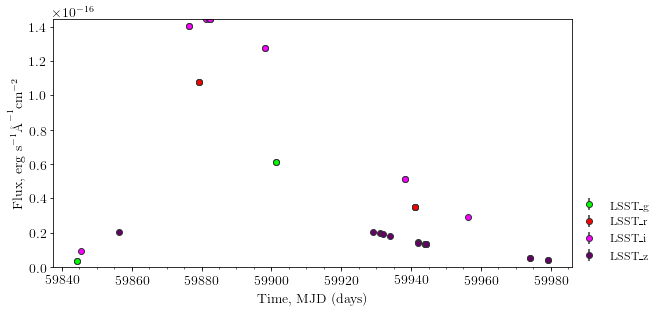

In [78]:
p.load_table(pt[w])
p.plot()

In [29]:
p = pcc.PhotometryClass()
ptable = simulate_out_to_ap_table(mjd_to_sim, out[0], out[1], filters_to_sim)

In [30]:
p.phot = ptable

In [ ]:
# mjdmax = testmjd[w[0]][0]
z_obs = 0.007
# mjd_to_sim = np.array(sn.phot.phot["MJD"])
# filters_to_sim = np.array([b(i.astype(str)) for i in sn.phot.phot["filter"]])

mjdmax = 100.0
mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
print(mjdmax)
print(mjd_to_sim)
print(filters_to_sim)

In [ ]:
out = coco.simulate(b"SN2009jf", 
                    z_obs, -0.0, 0.5, 0.5, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [ ]:
out